# **Clustering Models Assignment**



Data Collection:

* Cal Fire Statistics: Load data from Cal Fire statistics (e.g., PDF tables might need manual extraction or conversion to CSV).

* NASA MODIS Fire Detections: Use the NASA API to fetch fire detection data.

* USGS Streamflow Gaging Systems: Fetch data from USGS for streamflow and water levels.

* FEMA National Risk Index: Download and load data from FEMA's National Risk Index.

* NOAA Integrated Surface Data: Use NOAA's API to fetch weather data.

#### **For walkthrough and example code on how to load API, see the Logistic Regression notebook.**

## **Data Loading**

Load the relevant dataset you're looking at (FEMA, USDA, Cal Fire, etc.). If the data are not in CSV, or you are loading through an API, adjust the code accordingly.

In [97]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from pathlib import Path

# =========================
# Load Datasets
# =========================
#file_path_ca = Path("../Data/NRI_Table_Counties_California.csv")
file_path_tx = Path("../Data/NRI_Table_Counties_Texas.csv")
file_path_la = Path("../Data/NRI_Table_Counties_Louisiana.csv")
file_path_al = Path('../Data/NRI_Table_Counties_Alabama.csv')
file_path_fl = Path('../Data/NRI_Table_Counties_Florida.csv')
file_path_ms = Path('../Data/NRI_Table_Counties_Mississippi.csv')

file_path_us = Path('../Data/uscounties.csv')

#df_ca = pd.read_csv(file_path_ca)
df_tx = pd.read_csv(file_path_tx)
df_la = pd.read_csv(file_path_la)
df_al = pd.read_csv(file_path_al)
df_fl = pd.read_csv(file_path_fl)
df_us = pd.read_csv(file_path_us)

# =========================
# Combine California and Texas County Data
# =========================
states_combined_df = pd.concat([df_tx, df_la, df_al, df_fl])

# =========================
# Select Relevant Columns
# =========================

# Select relevant columns
nri_df = states_combined_df[['COUNTY', 'POPULATION', 'CFLD_RISKS', 'WFIR_RISKS']]

# =========================
# Get Latitude and Longitude Information
# =========================
filtered_us = df_us[df_us['state_id'].isin(['TX', 'LA', 'AL', 'FL', 'MS'])]
lat_lon_df = filtered_us[['county', 'lat', 'lng']]

# =========================
# Merge NRI data with Location Data
# =========================
merged_df = pd.merge(nri_df, lat_lon_df, left_on='COUNTY', right_on='county')
merged_df = merged_df.fillna(0)
merged_df = merged_df.drop('county', axis=1)

# =========================
# Standardize Risk and Population Data
# =========================
scaler = StandardScaler()

X_scaled_fire = scaler.fit_transform(merged_df[['WFIR_RISKS', 'POPULATION']])
X_scaled_flood = scaler.fit_transform(merged_df[['CFLD_RISKS', 'POPULATION']])

# =========================
# Final Data Check
# =========================
merged_df.tail(10)

,COUNTY,POPULATION,CFLD_RISKS,WFIR_RISKS,lat,lng
647,Union,16088,0.000000,84.123449,32.8318,-92.3748
648,Union,16088,0.000000,84.123449,30.0439,-82.3714
649,Volusia,551829,87.323944,98.218263,29.0584,-81.1819
650,Wakulla,33756,54.527163,91.473115,30.1673,-84.4007
651,Walton,75211,41.046278,81.482660,30.6436,-86.1697
652,Washington,25288,20.321932,75.182946,30.8533,-90.0405
653,Washington,25288,20.321932,75.182946,33.2839,-90.9474
654,Washington,25288,20.321932,75.182946,30.2145,-96.4034
655,Washington,25288,20.321932,75.182946,30.6106,-85.6653
656,Washington,25288,20.321932,75.182946,31.4076,-88.2079


# K-Means Clustering

K-Means clustering is an unsupervised machine learning algorithm used to group data points into k distinct clusters based on their similarity. It works by initializing k cluster centers, assigning data points to the nearest center, and iteratively adjusting the centers until convergence. The choice of k (the number of clusters) significantly impacts the quality of clustering. To determine the optimal k, we recommend using the Elbow Method, which analyzes the inertia (sum of squared distances) to find a point where adding more clusters no longer significantly improves the fit. Additionally, the Silhouette Score can be used to evaluate how well-separated the clusters are, with higher scores indicating better-defined clusters. **ASSIGNMENT: you should (1) load real geospatial risk datasets (FEMA, USDA, etc.), (2) test different k values using the methods above, (3) refine clustering by adding more relevant features (e.g., elevation, land cover), and (4) interpret the clusters to assess their effectiveness in identifying high-risk fire and flood areas**

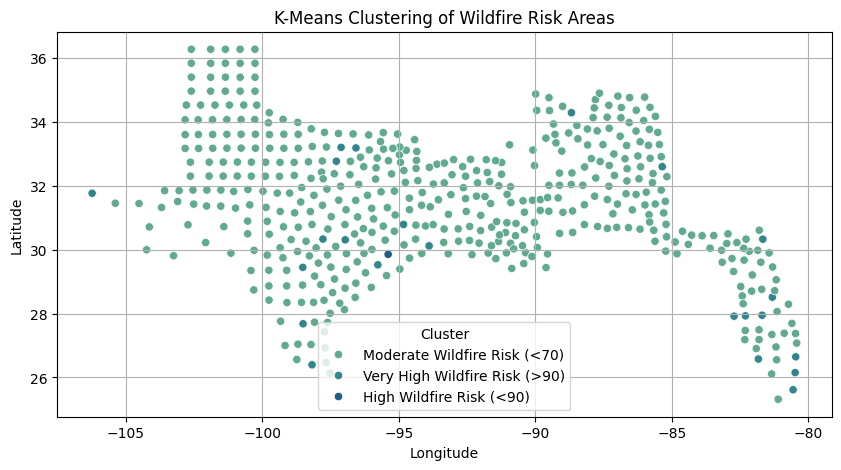

Silhouette Score for Wildfire Risk Clustering: 0.67


In [98]:
# =========================
# K-Means Clustering - Wildfire Risk
# =========================
kmeans_fire = KMeans(n_clusters=3, random_state=42)
merged_df['kmeans_fire_cluster'] = kmeans_fire.fit_predict(X_scaled_fire)

# =========================
# Assign descriptive wildfire risk labels
# =========================
risk_order = {
    0: "Moderate Wildfire Risk (<70)",
    2: "High Wildfire Risk (<90)",
    1: "Very High Wildfire Risk (>90)"
}
merged_df['risk_label'] = merged_df['kmeans_fire_cluster'].map(risk_order)

hue_order = ["Moderate Wildfire Risk (<70)", 
             "High Wildfire Risk (<90)", 
             "Very High Wildfire Risk (>90)"]

# Plotting wildfire clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=merged_df,
    x='lng',
    y='lat',
    hue='risk_label',
    palette='crest'
)
plt.title("K-Means Clustering of Wildfire Risk Areas")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# =========================
# Silhouette Score Evaluation (Wildfire)
# =========================
silhouette_fire = silhouette_score(X_scaled_fire, merged_df['kmeans_fire_cluster'])
print(f"Silhouette Score for Wildfire Risk Clustering: {silhouette_fire:.2f}")


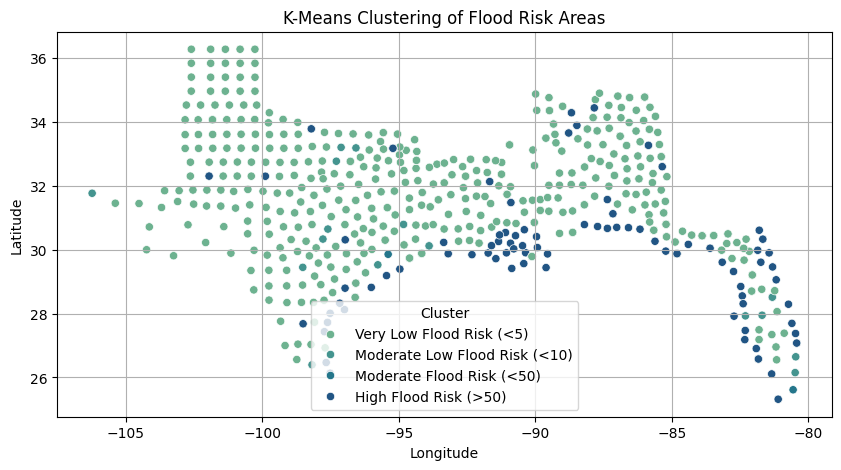

Silhouette Score for Flood Risk Clustering: 0.79


In [99]:
# =========================
# K-Means Clustering - Flood Risk
# =========================
kmeans_flood = KMeans(n_clusters=4, random_state=42)
merged_df['kmeans_flood_cluster'] = kmeans_flood.fit_predict(X_scaled_flood)

# =========================
# Assign descriptive flood risk labels
# =========================
flood_order = {
    0: "Very Low Flood Risk (<5)",
    3: "Moderate Low Flood Risk (<10)",
    2: "Moderate Flood Risk (<50)",
    1: "High Flood Risk (>50)"
}
merged_df['flood_label'] = merged_df['kmeans_flood_cluster'].map(flood_order)

flood_hue_order = [
    "Very Low Flood Risk (<5)",
    "Moderate Low Flood Risk (<10)",
    "Moderate Flood Risk (<50)",
    "High Flood Risk (>50)"
]

# Plotting flood clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=merged_df,
    x='lng',
    y='lat',
    hue='flood_label',
    hue_order=flood_hue_order,
    palette='crest'
)
plt.title("K-Means Clustering of Flood Risk Areas")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# =========================
# Silhouette Score Evaluation (Flood)
# =========================
silhouette_flood = silhouette_score(X_scaled_flood, merged_df['kmeans_flood_cluster'])
print(f"Silhouette Score for Flood Risk Clustering: {silhouette_flood:.2f}")

In [100]:
# =========================
# Load Datasets
# =========================
rubicon_path = Path('../Data/DeployableGreyshirts_Qualifications.xlsx - US Deployable Greyshirts.csv')
zip_path = Path('../Data/uszips.csv')

rubicon_df = pd.read_csv(rubicon_path)
zip_df = pd.read_csv(zip_path)

# =========================
# Filter Zip Codes for Included States
# =========================
all_states_zipcodes = zip_df[zip_df['state_id'].isin(['TX', 'LA', 'AL', 'FL', 'MS'])]

# =========================
# Clean Zip Codes in rubicon_df
# =========================
# Coerce 'Zip/Postal Code ID' to numeric (turn invalid entries into NaN), then drop missing
rubicon_df['Zip/Postal Code ID'] = pd.to_numeric(rubicon_df['Zip/Postal Code ID'], errors='coerce')
rubicon_df = rubicon_df.dropna(subset=['Zip/Postal Code ID'])
rubicon_df['Zip/Postal Code ID'] = rubicon_df['Zip/Postal Code ID'].astype(int)

# =========================
# Merge Datasets on Zip Code
# =========================
zipcodes_merged = pd.merge(
    all_states_zipcodes,
    rubicon_df,
    left_on='zip',
    right_on='Zip/Postal Code ID'
)

# =========================
# Check Column Names
# =========================
zipcodes_merged.columns

C:\Users\Jessi\AppData\Local\Temp\ipykernel_10976\3953959162.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  rubicon_df = pd.read_csv(rubicon_path)


Index(['zip', 'lat', 'lng', 'city', 'state_id', 'state_name', 'zcta',
       'parent_zcta', 'population', 'density', 'county_fips', 'county_name',
       'county_weights', 'county_names_all', 'county_fips_all', 'imprecise',
       'military', 'timezone', '(Do Not Modify) Contact ID',
       '(Do Not Modify) Row Checksum', '(Do Not Modify) Modified On',
       'User ID', 'Created On', 'Date Deployable', 'Zip/Postal Code ID',
       'City', 'Metro', 'State/Province', 'Branch', '# of Deployments',
       'HEO-1 Q?', 'HEO-2 Q?', 'HEO-2(CTL) Q?', 'HEO-2(EX) Q?', 'HEO-3 Q?',
       'HESI Q?', 'HIZ Trained C?', 'C2 Q?', 'CI Q?', 'CI-2 Q?', 'Sawyer 1 Q?',
       'Sawyer 2 Q?', 'Advanced Sawyer 1 Q?', 'RC HEO C?', 'RC Saw C?',
       'RC TFL C?', 'R/A Q?', 'SS Qual?', 'Core Ops Q?', 'Roof Tarping C?',
       'STL Trained C?'],
      dtype='object')

In [101]:
# =========================
# Keep Only Necessary Columns
# =========================
zipcodes_merged = zipcodes_merged[['zip', 'lat', 'lng', 'city', 'state_id', 'population', 'county_name',
                                   '# of Deployments']]
zipcodes_merged.head()

,zip,lat,lng,city,state_id,population,county_name,# of Deployments
0,32003,30.09813,-81.71255,Fleming Island,FL,29351.0,Clay,2
1,32003,30.09813,-81.71255,Fleming Island,FL,29351.0,Clay,0
2,32003,30.09813,-81.71255,Fleming Island,FL,29351.0,Clay,2
3,32003,30.09813,-81.71255,Fleming Island,FL,29351.0,Clay,0
4,32003,30.09813,-81.71255,Fleming Island,FL,29351.0,Clay,0


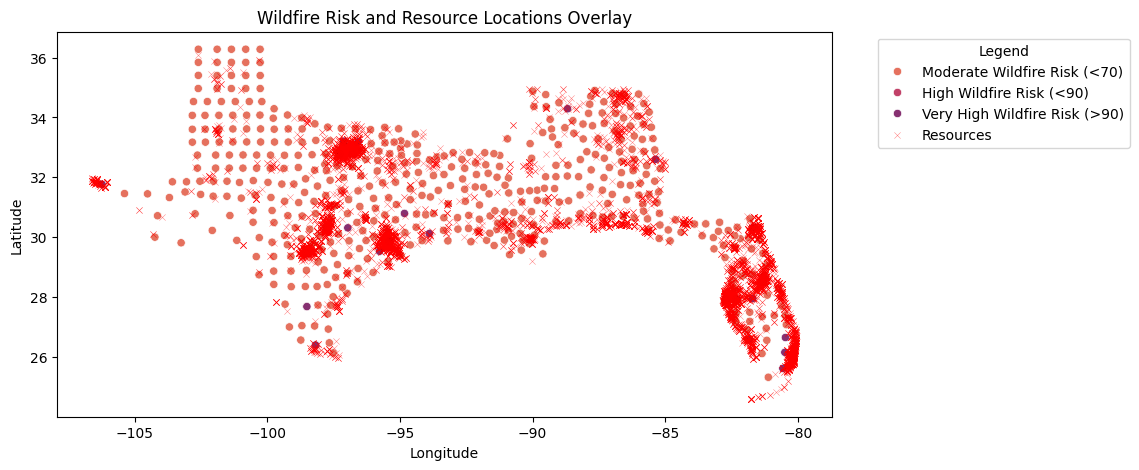

In [102]:
# =========================
# Plot Wildfire Risk Clusters
# =========================
plt.figure(figsize=(10, 5))

# Wildfire clusters first
sns.scatterplot(
    data=merged_df,
    x='lng',
    y='lat',
    hue='risk_label',
    hue_order=hue_order,
    palette='flare',
    legend='full'
)

# =========================
# Overlay Resource Locations
# =========================
sns.scatterplot(
    data=zipcodes_merged,
    x='lng',
    y='lat',
    alpha = 0.5,
    color='red',
    marker='x',
    s=20,
    label='Resources'
)

plt.title("Wildfire Risk and Resource Locations Overlay")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

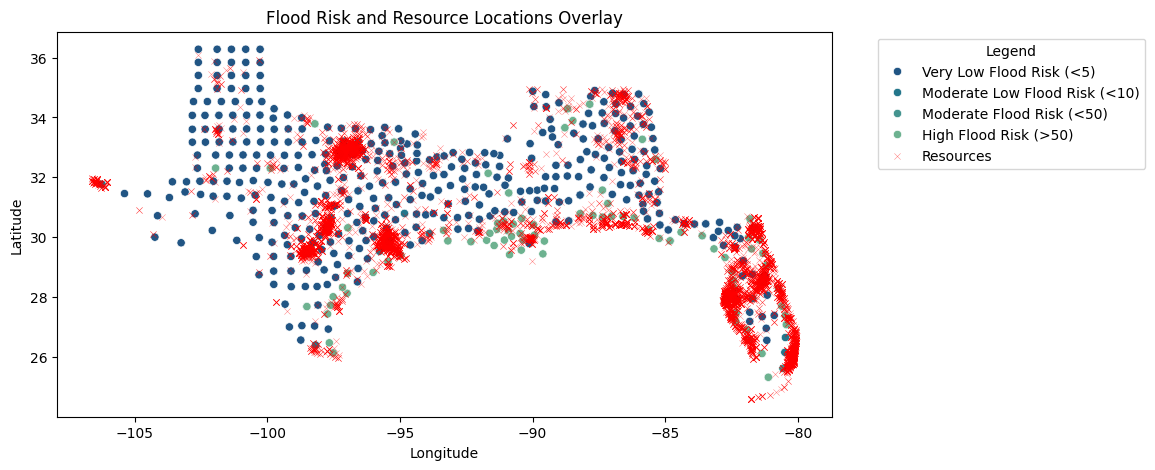

In [105]:
# =========================
# Plot Flood Risk Clusters
# =========================
plt.figure(figsize=(10, 5))

# Flood risk clusters first
sns.scatterplot(
    data=merged_df,
    x='lng',
    y='lat',
    hue='flood_label',
    hue_order=flood_hue_order,
    palette='crest_r',
    legend='full'
)

# =========================
# Overlay Resource Locations
# =========================
sns.scatterplot(
    data=zipcodes_merged,
    x='lng',
    y='lat',
    alpha = 0.5,
    color='red',
    marker='x',
    s=20,
    label='Resources'
)

# =========================
# Plot Settings
# =========================
plt.title("Flood Risk and Resource Locations Overlay")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(False)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [106]:
# Transform CSV files into JSON
import os

csv_folder = Path("../Data")
for file in csv_folder.glob("*.csv"):
    df = pd.read_csv(file)
    json_path = file.with_suffix(".json")
    df.to_json(json_path, orient="records", indent=2)

C:\Users\Jessi\AppData\Local\Temp\ipykernel_10976\666987156.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
